In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

# Model 

In [2]:
# =========================
# LIAR 6-class Hybrid CNN (Updated, clean, reproducible)
# Text CNN + metadata + credit-history (with leakage fix)
# =========================
# =========================

# ---- Cell 0: Imports + reproducibility ----
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()  # reproducible, slower

# ---- Cell 1: Load data ----
traindf = pd.read_csv("train.tsv", sep="\t")
valdf   = pd.read_csv("valid.tsv", sep="\t")
testdf  = pd.read_csv("test.tsv",  sep="\t")

print("Shapes:", traindf.shape, valdf.shape, testdf.shape)

# ---- Cell 2: Standardize columns + fill missing ----
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    ren = {
        "speaker_job_title": "speakerjobtitle",
        "barely_true_counts": "barelytruecounts",
        "false_counts": "falsecounts",
        "half_true_counts": "halftruecounts",
        "mostly_true_counts": "mostlytruecounts",
        "pants_on_fire_counts": "pantsonfirecounts",
    }
    df.rename(columns={k: v for k, v in ren.items() if k in df.columns}, inplace=True)

    # Ensure required columns exist
    for c in [
        "id","label","statement","subjects","speaker","speakerjobtitle","state","party",
        "barelytruecounts","falsecounts","halftruecounts","mostlytruecounts","pantsonfirecounts",
        "context"
    ]:
        if c not in df.columns:
            df[c] = np.nan

    # Fill text/categorical columns
    df["statement"] = df["statement"].fillna("").astype(str)
    for c in ["subjects","speaker","speakerjobtitle","state","party","context"]:
        df[c] = df[c].fillna("unknown").astype(str).str.strip().replace("", "unknown")

    # Numeric history cols
    for c in ["barelytruecounts","falsecounts","halftruecounts","mostlytruecounts","pantsonfirecounts"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    return df

traindf = standardize_columns(traindf)
valdf   = standardize_columns(valdf)
testdf  = standardize_columns(testdf)

# ---- Cell 3: (Recommended) Merge contextgroup if file exists ----

CTX_COL = "context"  # default

if os.path.exists("context_groups.csv"):
    contextgroups = pd.read_csv("context_groups.csv")

    # rename to what our model code expects
    contextgroups = contextgroups.rename(columns={"context_group": "contextgroup"})

    # keep only needed columns
    contextgroups = contextgroups[["context", "contextgroup"]]

    # merge (same as your notebook_cells.py: left join + fill Other)  # [file:42]
    traindf = traindf.merge(contextgroups, on="context", how="left")
    valdf   = valdf.merge(contextgroups, on="context", how="left")
    testdf  = testdf.merge(contextgroups, on="context", how="left")

    for d in (traindf, valdf, testdf):
        d["contextgroup"] = d["contextgroup"].fillna("Other").astype(str)

    CTX_COL = "contextgroup"
    print("Merged contextgroup OK. Unique:", traindf["contextgroup"].nunique())
else:
    print("context_groups.csv not found -> using raw context.")



def get_context_feature(df):
    return "contextgroup" if "contextgroup" in df.columns else "context"

CTX_COL = get_context_feature(traindf)

# ---- Cell 4: Labels (6-class) ----
LABELS = ["pants-fire", "FALSE", "barely-true", "half-true", "mostly-true", "TRUE"]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

def map_labels(df):
    y = df["label"].astype(str).str.strip()
    y = y.replace({"true": "TRUE", "false": "FALSE"})
    unknown = set(y.unique()) - set(LABELS)
    if unknown:
        raise ValueError(f"Unexpected labels found: {unknown}")
    return y.map(label2id).astype("int32").values

y_train = map_labels(traindf)
y_val   = map_labels(valdf)
y_test  = map_labels(testdf)

# ---- Cell 5: Credit-history matrix + leakage fix ----
HIST_COLS = ["barelytruecounts","falsecounts","halftruecounts","mostlytruecounts","pantsonfirecounts"]

label_to_histcol = {
    "barely-true": "barelytruecounts",
    "FALSE": "falsecounts",
    "half-true": "halftruecounts",
    "mostly-true": "mostlytruecounts",
    "pants-fire": "pantsonfirecounts",
    # "TRUE" has no column in this schema
}

def history_matrix(df: pd.DataFrame) -> np.ndarray:
    X = df[HIST_COLS].values.astype("float32")
    labels = df["label"].astype(str).str.strip().replace({"true":"TRUE","false":"FALSE"}).values
    for i, lab in enumerate(labels):
        col = label_to_histcol.get(lab, None)
        if col is None:
            continue
        j = HIST_COLS.index(col)
        X[i, j] = max(0.0, X[i, j] - 1.0)
    return X

Xhist_train = history_matrix(traindf)
Xhist_val   = history_matrix(valdf)
Xhist_test  = history_matrix(testdf)

# ---- Cell 6: Cap high-cardinality categorical features (do BEFORE lookups) ----
def cap_top_n(train_df, other_df, col, n):
    top = set(train_df[col].value_counts().head(n).index)
    def cap(df):
        df = df.copy()
        df[col] = df[col].where(df[col].isin(top), other="other")
        return df
    return cap(train_df), cap(other_df)

# speaker / subjects / jobtitle can memorize; EDA showed many uniques [file:41]
traindf, valdf  = cap_top_n(traindf, valdf,  "speaker",         n=500)
traindf, testdf = cap_top_n(traindf, testdf, "speaker",         n=500)

traindf, valdf  = cap_top_n(traindf, valdf,  "subjects",        n=500)
traindf, testdf = cap_top_n(traindf, testdf, "subjects",        n=500)

traindf, valdf  = cap_top_n(traindf, valdf,  "speakerjobtitle", n=200)
traindf, testdf = cap_top_n(traindf, testdf, "speakerjobtitle", n=200)

# ---- Cell 7: Text vectorizer ----
max_tokens = 50000
seq_len = 64

text_vec = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len,
    standardize="lower_and_strip_punctuation",
    split="whitespace"
)
text_vec.adapt(traindf["statement"].values)

# ---- Cell 8: Build hybrid CNN ----
# cat_cols = ["party", "state", CTX_COL, "speakerjobtitle", "speaker", "subjects"]
cat_cols = ["party", "state", CTX_COL, "speakerjobtitle", "speaker", "subjects"]


text_in = keras.Input(shape=(1,), dtype=tf.string, name="statement")
hist_in = keras.Input(shape=(len(HIST_COLS),), dtype=tf.float32, name="history")
cat_inputs = {c: keras.Input(shape=(1,), dtype=tf.string, name=c) for c in cat_cols}

# Text branch
x = text_vec(text_in)
# x = layers.Embedding(max_tokens, 100, name="word_emb")(x)
x = layers.Embedding(max_tokens, 100, name="word_emb",
                     embeddings_regularizer=regularizers.l2(1e-6))(x)

x = layers.SpatialDropout1D(0.2)(x)

conv_outs = []
for k in [2, 3, 4]:
    c = layers.Conv1D(
        128, k, activation="relu",
        kernel_regularizer=regularizers.l2(1e-5)
    )(x)
    c = layers.GlobalMaxPooling1D()(c)
    conv_outs.append(c)

text_feat = layers.Concatenate()(conv_outs)
text_feat = layers.Dropout(0.4)(text_feat)

# Metadata branch
meta_feats = []
for c in cat_cols:
    lookup = layers.StringLookup(output_mode="int", name=f"{c}_lookup")
    lookup.adapt(traindf[c].values)

    vocab_size = lookup.vocabulary_size()
    emb_dim = int(min(32, np.ceil(np.sqrt(vocab_size))))

    e = lookup(cat_inputs[c])
    e = layers.Embedding(vocab_size, emb_dim, name=f"{c}_emb")(e)
    e = layers.Reshape((emb_dim,))(e)
    meta_feats.append(e)

meta_feat = layers.Concatenate()(meta_feats + [hist_in])
meta_feat = layers.Dense(
    128, activation="relu",
    kernel_regularizer=regularizers.l2(1e-5)
)(meta_feat)
meta_feat = layers.Dropout(0.4)(meta_feat)

# Head
z = layers.Concatenate()([text_feat, meta_feat])
z = layers.Dense(
    128, activation="relu",
    kernel_regularizer=regularizers.l2(1e-5)
)(z)
z = layers.Dropout(0.5)(z)
out = layers.Dense(len(LABELS), activation="softmax", name="y")(z)

model = keras.Model(inputs=[text_in, hist_in] + list(cat_inputs.values()), outputs=out)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# ---- Cell 9: Build input dicts ----
def make_inputs(df, Xhist):
    inputs = {"statement": df["statement"].values, "history": Xhist}
    for c in cat_cols:
        inputs[c] = df[c].values
    return inputs

train_inputs = make_inputs(traindf, Xhist_train)
val_inputs   = make_inputs(valdf,   Xhist_val)
test_inputs  = make_inputs(testdf,  Xhist_test)

# ---- Cell 10: Train ----
# callbacks = [
#     keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
#     keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5),
# ]


callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        min_lr=1e-5,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,              # usually 3 works better with LR drops
        restore_best_weights=True
    )
]



from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.arange(len(LABELS))
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {i: w for i, w in enumerate(cw)}
print("class_weight:", class_weight)



# history = model.fit(
#     train_inputs, y_train,
#     validation_data=(val_inputs, y_val),
#     epochs=15,
#     batch_size=64,
#     callbacks=callbacks,
#     verbose=1
# )

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)



# ---- Cell 11: Evaluate + report ----
from sklearn.metrics import classification_report, confusion_matrix

probs = model.predict(test_inputs, verbose=0)
pred = probs.argmax(axis=1)

print("Test metrics:", dict(zip(model.metrics_names, model.evaluate(test_inputs, y_test, verbose=0))))
print(classification_report(y_test, pred, target_names=LABELS, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


Shapes: (10240, 14) (1284, 14) (1267, 14)
Merged contextgroup OK. Unique: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ statement (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_vectorization            │ (None, 64)                │               0 │ statement[0][0]            │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ party (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ state (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ contextgroup (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speakerjobtitle (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speaker (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ subjects (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ word_emb (Embedding)          │ (None, 64, 100)           │       5,000,000 │ text_vectorization[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ party_lookup (StringLookup)   │ (None, 1)                 │               0 │ party[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ state_lookup (StringLookup)   │ (None, 1)                 │               0 │ state[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ contextgroup_lookup           │ (None, 1)                 │               0 │ contextgroup[0][0]         │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speakerjobtitle_lookup        │ (None, 1)                 │               0 │ speakerjobtitle[0][0]      │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speaker_lookup (StringLookup) │ (None, 1)                 │               0 │ speaker[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ subjects_lookup               │ (None, 1)                 │               0 │ subjects[0][0]             │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,219,780 (19.91 MB)

 Trainable params: 5,219,780 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

class_weight: {0: np.float64(2.0336101225780943), 1: np.float64(0.8558828424030621), 2: np.float64(1.0277777777777777), 3: np.float64(0.8067450980392157), 4: np.float64(0.8715471953906118), 5: np.float64(1.0204365079365079)}
Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.1874 - loss: 2.3143 - val_accuracy: 0.1698 - val_loss: 1.7775 - learning_rate: 0.0010
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.1731 - loss: 1.7978 - val_accuracy: 0.2093 - val_loss: 1.7647 - learning_rate: 0.0010
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.1950 - loss: 1.7808 - val_accuracy: 0.2527 - val_loss: 1.7568 - learning_rate: 0.0010
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.2017 - loss: 1.7625 - val_accuracy: 0.2535 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.2226 - loss: 1.7147 - val_accuracy: 0.2233 - val_loss: 1.7117 - learning_rate: 0.0010
Epoc

In [3]:
# =========================
# LIAR 6-class Hybrid CNN (Clean, reproducible)
# Text CNN + metadata + credit-history (with leakage fix)
# =========================
# Requires: train.tsv, valid.tsv, test.tsv
# =========================

# ---- Cell 0: Imports + reproducibility ----
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()  # reproducible, slower

# ---- Cell 1: Load data ----
traindf = pd.read_csv("train.tsv", sep="\t")
valdf   = pd.read_csv("valid.tsv", sep="\t")
testdf  = pd.read_csv("test.tsv",  sep="\t")
print("Shapes:", traindf.shape, valdf.shape, testdf.shape)

# ---- Cell 2: Standardize columns + fill missing ----
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    ren = {
        "speaker_job_title": "speakerjobtitle",
        "barely_true_counts": "barelytruecounts",
        "false_counts": "falsecounts",
        "half_true_counts": "halftruecounts",
        "mostly_true_counts": "mostlytruecounts",
        "pants_on_fire_counts": "pantsonfirecounts",
    }
    df.rename(columns={k: v for k, v in ren.items() if k in df.columns}, inplace=True)

    # Ensure required columns exist
    for c in [
        "id","label","statement","subjects","speaker","speakerjobtitle","state","party",
        "barelytruecounts","falsecounts","halftruecounts","mostlytruecounts","pantsonfirecounts",
        "context"
    ]:
        if c not in df.columns:
            df[c] = np.nan

    # Fill text/categorical columns
    df["statement"] = df["statement"].fillna("").astype(str)
    for c in ["subjects","speaker","speakerjobtitle","state","party","context"]:
        df[c] = df[c].fillna("unknown").astype(str).str.strip().replace("", "unknown")

    # Numeric history cols
    for c in ["barelytruecounts","falsecounts","halftruecounts","mostlytruecounts","pantsonfirecounts"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    return df

traindf = standardize_columns(traindf)
valdf   = standardize_columns(valdf)
testdf  = standardize_columns(testdf)

# ---- Cell 3: (Recommended) Merge contextgroup if file exists ----
CTX_COL = "context"  # default

if os.path.exists("context_groups.csv"):
    contextgroups = pd.read_csv("context_groups.csv")

    # accept either context_group or contextgroup
    if "context_group" in contextgroups.columns and "contextgroup" not in contextgroups.columns:
        contextgroups = contextgroups.rename(columns={"context_group": "contextgroup"})

    # keep only needed columns (must contain "context" + "contextgroup")
    contextgroups = contextgroups[["context", "contextgroup"]]

    # merge (left join + fill Other)
    traindf = traindf.merge(contextgroups, on="context", how="left")
    valdf   = valdf.merge(contextgroups, on="context", how="left")
    testdf  = testdf.merge(contextgroups, on="context", how="left")

    for d in (traindf, valdf, testdf):
        d["contextgroup"] = d["contextgroup"].fillna("Other").astype(str)

    CTX_COL = "contextgroup"
    print("Merged contextgroup OK. Unique:", traindf["contextgroup"].nunique())
else:
    print("context_groups.csv not found -> using raw context.")

# ---- Cell 4: Labels (6-class) ----
LABELS = ["pants-fire", "FALSE", "barely-true", "half-true", "mostly-true", "TRUE"]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

def map_labels(df):
    y = df["label"].astype(str).str.strip()
    y = y.replace({"true": "TRUE", "false": "FALSE"})
    unknown = set(y.unique()) - set(LABELS)
    if unknown:
        raise ValueError(f"Unexpected labels found: {unknown}")
    return y.map(label2id).astype("int32").values

y_train = map_labels(traindf)
y_val   = map_labels(valdf)
y_test  = map_labels(testdf)

# ---- Cell 5: Credit-history matrix + leakage fix ----
HIST_COLS = ["barelytruecounts","falsecounts","halftruecounts","mostlytruecounts","pantsonfirecounts"]

label_to_histcol = {
    "barely-true": "barelytruecounts",
    "FALSE": "falsecounts",
    "half-true": "halftruecounts",
    "mostly-true": "mostlytruecounts",
    "pants-fire": "pantsonfirecounts",
    # "TRUE" has no column in this schema
}

def history_matrix(df: pd.DataFrame) -> np.ndarray:
    X = df[HIST_COLS].values.astype("float32")
    labels = df["label"].astype(str).str.strip().replace({"true":"TRUE","false":"FALSE"}).values
    for i, lab in enumerate(labels):
        col = label_to_histcol.get(lab, None)
        if col is None:
            continue
        j = HIST_COLS.index(col)
        X[i, j] = max(0.0, X[i, j] - 1.0)  # leakage fix
    return X

Xhist_train = history_matrix(traindf)
Xhist_val   = history_matrix(valdf)
Xhist_test  = history_matrix(testdf)

# ---- Cell 6: Cap high-cardinality categorical features (do BEFORE lookups) ----
def cap_top_n(train_df, other_df, col, n):
    top = set(train_df[col].value_counts().head(n).index)
    def cap(df):
        df = df.copy()
        df[col] = df[col].where(df[col].isin(top), other="other")
        return df
    return cap(train_df), cap(other_df)

traindf, valdf  = cap_top_n(traindf, valdf,  "speaker",         n=500)
traindf, testdf = cap_top_n(traindf, testdf, "speaker",         n=500)

traindf, valdf  = cap_top_n(traindf, valdf,  "subjects",        n=500)
traindf, testdf = cap_top_n(traindf, testdf, "subjects",        n=500)

traindf, valdf  = cap_top_n(traindf, valdf,  "speakerjobtitle", n=200)
traindf, testdf = cap_top_n(traindf, testdf, "speakerjobtitle", n=200)

# ---- Cell 7: Text vectorizer ----
max_tokens = 50000
seq_len = 64

text_vec = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len,
    standardize="lower_and_strip_punctuation",
    split="whitespace"
)
text_vec.adapt(traindf["statement"].values)

# ---- Cell 8: Build hybrid CNN ----
cat_cols = ["party", "state", CTX_COL, "speakerjobtitle", "speaker", "subjects"]

text_in = keras.Input(shape=(1,), dtype=tf.string, name="statement")
hist_in = keras.Input(shape=(len(HIST_COLS),), dtype=tf.float32, name="history")
cat_inputs = {c: keras.Input(shape=(1,), dtype=tf.string, name=c) for c in cat_cols}

# Text branch
x = text_vec(text_in)
x = layers.Embedding(
    max_tokens, 100, name="word_emb",
    embeddings_regularizer=regularizers.l2(1e-6)
)(x)
x = layers.SpatialDropout1D(0.2)(x)

conv_outs = []
for k in [2, 3, 4]:
    c = layers.Conv1D(
        128, k, activation="relu",
        kernel_regularizer=regularizers.l2(1e-5)
    )(x)
    c = layers.GlobalMaxPooling1D()(c)
    conv_outs.append(c)

text_feat = layers.Concatenate()(conv_outs)
text_feat = layers.Dropout(0.4)(text_feat)

# Metadata branch
meta_feats = []
for c in cat_cols:
    lookup = layers.StringLookup(output_mode="int", name=f"{c}_lookup")
    lookup.adapt(traindf[c].values)

    vocab_size = lookup.vocabulary_size()
    emb_dim = int(min(32, np.ceil(np.sqrt(vocab_size))))

    e = lookup(cat_inputs[c])
    e = layers.Embedding(vocab_size, emb_dim, name=f"{c}_emb")(e)
    e = layers.Reshape((emb_dim,))(e)
    meta_feats.append(e)

meta_feat = layers.Concatenate()(meta_feats + [hist_in])
meta_feat = layers.Dense(
    128, activation="relu",
    kernel_regularizer=regularizers.l2(1e-5)
)(meta_feat)
meta_feat = layers.Dropout(0.4)(meta_feat)

# Head
z = layers.Concatenate()([text_feat, meta_feat])
z = layers.Dense(
    128, activation="relu",
    kernel_regularizer=regularizers.l2(1e-5)
)(z)
z = layers.Dropout(0.5)(z)
out = layers.Dense(len(LABELS), activation="softmax", name="y")(z)

model = keras.Model(inputs=[text_in, hist_in] + list(cat_inputs.values()), outputs=out)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# ---- Cell 9: Build input dicts ----
def make_inputs(df, Xhist):
    inputs = {"statement": df["statement"].values, "history": Xhist}
    for c in cat_cols:
        inputs[c] = df[c].values
    return inputs

train_inputs = make_inputs(traindf, Xhist_train)
val_inputs   = make_inputs(valdf,   Xhist_val)
test_inputs  = make_inputs(testdf,  Xhist_test)

# ---- Cell 10: Train ----
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        min_lr=1e-5,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# ---- Cell 11: Evaluate + report ----
from sklearn.metrics import classification_report, confusion_matrix

probs = model.predict(test_inputs, verbose=0)
pred = probs.argmax(axis=1)

print("Test metrics:", dict(zip(model.metrics_names, model.evaluate(test_inputs, y_test, verbose=0))))
print(classification_report(y_test, pred, target_names=LABELS, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


Shapes: (10240, 14) (1284, 14) (1267, 14)
Merged contextgroup OK. Unique: 10


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ statement (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_vectorization_1          │ (None, 64)                │               0 │ statement[0][0]            │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ party (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ state (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ contextgroup (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speakerjobtitle (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speaker (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ subjects (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ word_emb (Embedding)          │ (None, 64, 100)           │       5,000,000 │ text_vectorization_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ party_lookup (StringLookup)   │ (None, 1)                 │               0 │ party[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ state_lookup (StringLookup)   │ (None, 1)                 │               0 │ state[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ contextgroup_lookup           │ (None, 1)                 │               0 │ contextgroup[0][0]         │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speakerjobtitle_lookup        │ (None, 1)                 │               0 │ speakerjobtitle[0][0]      │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speaker_lookup (StringLookup) │ (None, 1)                 │               0 │ speaker[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ subjects_lookup               │ (None, 1)                 │               0 │ subjects[0][0]             │
│ (StringLookup)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,219,780 (19.91 MB)

 Trainable params: 5,219,780 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.2042 - loss: 2.2772 - val_accuracy: 0.2054 - val_loss: 1.7525 - learning_rate: 0.0010
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.2134 - loss: 1.7708 - val_accuracy: 0.2357 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.2301 - loss: 1.7429 - val_accuracy: 0.2612 - val_loss: 1.7187 - learning_rate: 0.0010
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.2577 - loss: 1.7076 - val_accuracy: 0.2620 - val_loss: 1.7063 - learning_rate: 0.0010
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2936 - loss: 1.6586
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.2998 - loss: 1.6313 - val_accuracy: 0.2705 - val_loss: 1.7309 - learning_rate: 0.0010
Epoch 6/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3479 - lo

In [4]:
# different approch

In [5]:
# train_ordinal.py
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

LABELS = ["pants-fire","FALSE","barely-true","half-true","mostly-true","TRUE"]
LABEL2ID = {l:i for i,l in enumerate(LABELS)}

# Ordinal: 6 classes => 5 thresholds
# y_ord[k] = 1 if class_id > k else 0  (or >= depending on convention)
def to_ordinal_targets(y_ids, num_classes=6):
    y_ids = np.asarray(y_ids, dtype=np.int32)
    K = num_classes - 1
    out = np.zeros((len(y_ids), K), dtype=np.float32)
    for k in range(K):
        out[:, k] = (y_ids > k).astype(np.float32)
    return out

def load_data(train_path, valid_path, test_path, context_map_csv):
    train = pd.read_csv(train_path, sep="\t")
    valid = pd.read_csv(valid_path, sep="\t")
    test  = pd.read_csv(test_path,  sep="\t")

    ctx = pd.read_csv(context_map_csv)  # columns: context, contextgroup [file:40]
    for df in (train, valid, test):
        df["label_id"] = df["label"].map(LABEL2ID)
        df = df.merge(ctx, on="context", how="left")  # same as notebook_cells.py [file:42]
        df["contextgroup"] = df["contextgroup"].fillna("Other")
    return train, valid, test

def leakage_safe_history(df):
    # history counts columns in LIAR format (as in the paper) [file:43]
    cols = ["pantsonfirecounts","falsecounts","barelytruecounts",
            "halftruecounts","mostlytruecounts"]
    # Map label -> which count to decrement (paper warning: current label is included) [file:43]
    # Order differs: paper's example vector is {pants-fire,false,barely-true,half-true,mostly-true} [file:43]
    dec_map = {
        "pants-fire":"pantsonfirecounts",
        "FALSE":"falsecounts",
        "barely-true":"barelytruecounts",
        "half-true":"halftruecounts",
        "mostly-true":"mostlytruecounts",
        # "TRUE" is not in history vector in this dataset schema
    }
    df = df.copy()
    for lab, col in dec_map.items():
        m = (df["label"] == lab) & df[col].notna()
        df.loc[m, col] = df.loc[m, col] - 1.0
    df[cols] = df[cols].fillna(0.0).clip(lower=0.0)
    return df

def build_model(vocab_size=40000, text_len=64,
                speaker_vocab=50000, party_vocab=1000, state_vocab=200,
                job_vocab=50000, ctx_vocab=50,
                embed_dim=128):
    # Inputs
    statement = tf.keras.Input(shape=(), dtype=tf.string, name="statement")
    speaker   = tf.keras.Input(shape=(), dtype=tf.string, name="speaker")
    party     = tf.keras.Input(shape=(), dtype=tf.string, name="party")
    state     = tf.keras.Input(shape=(), dtype=tf.string, name="state")
    job       = tf.keras.Input(shape=(), dtype=tf.string, name="speakerjobtitle")
    ctxgrp    = tf.keras.Input(shape=(), dtype=tf.string, name="contextgroup")
    history   = tf.keras.Input(shape=(5,), dtype=tf.float32, name="history")

    # Text vectorization
    vec = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size, output_mode="int",
        output_sequence_length=text_len
    )
    # We'll adapt() vec later on train statements

    x = vec(statement)
    x = tf.keras.layers.Embedding(vocab_size, embed_dim)(x)
    x = tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.GlobalMaxPool1D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Categorical embeddings
    def cat_embed(inp, max_tokens, name):
        lookup = tf.keras.layers.StringLookup(max_tokens=max_tokens, output_mode="int", name=f"{name}_lookup")
        emb = tf.keras.layers.Embedding(max_tokens, 32, name=f"{name}_emb")
        z = lookup(inp)
        z = emb(z)
        return lookup, tf.keras.layers.Flatten()(z)

    speaker_lookup, z_speaker = cat_embed(speaker, speaker_vocab, "speaker")
    party_lookup,   z_party   = cat_embed(party,   party_vocab,   "party")
    state_lookup,   z_state   = cat_embed(state,   state_vocab,   "state")
    job_lookup,     z_job     = cat_embed(job,     job_vocab,     "job")
    ctx_lookup,     z_ctx     = cat_embed(ctxgrp,  ctx_vocab,     "ctxgrp")

    h = tf.keras.layers.Concatenate()([x, z_speaker, z_party, z_state, z_job, z_ctx, history])
    h = tf.keras.layers.Dense(256, activation="relu")(h)
    h = tf.keras.layers.Dropout(0.3)(h)

    # Ordinal head: 5 sigmoids
    out = tf.keras.layers.Dense(5, activation="sigmoid", name="ordinal")(h)
    model = tf.keras.Model(
        inputs={"statement":statement,"speaker":speaker,"party":party,"state":state,
                "speakerjobtitle":job,"contextgroup":ctxgrp,"history":history},
        outputs=out
    )

    model._vectorizer = vec
    model._lookups = (speaker_lookup, party_lookup, state_lookup, job_lookup, ctx_lookup)
    return model

def ordinal_to_class(pred):
    # pred shape: (N,5) probabilities; count how many thresholds passed
    return (pred > 0.5).sum(axis=1)

# You'd implement:
# - vectorizer.adapt(train["statement"])
# - lookup.adapt(train[col]) for each categorical
# - model.fit(...)
# - eval: convert ordinal->class, compute macro-F1, report


In [6]:
#!/usr/bin/env python3
"""
Ordinal Keras model for LIAR + metadata + leakage-safe history.

Run:
  pip install tensorflow pandas scikit-learn
  python train_ordinal_keras.py --train train.tsv --valid valid.tsv --test test.tsv --context_map context_groups.csv

Outputs:
  models/liar_ordinal.keras
  metrics/liar_ordinal_metrics.json
"""

import os, json, argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

LABELS = ["pants-fire", "FALSE", "barely-true", "half-true", "mostly-true", "TRUE"]
LABEL2ID = {l: i for i, l in enumerate(LABELS)}
ID2LABEL = {i: l for l, i in LABEL2ID.items()}

HIST_COLS_CANON = [
    "pants_on_fire_counts",
    "false_counts",
    "barely_true_counts",
    "half_true_counts",
    "mostly_true_counts",
]

def set_seed(seed: int = 42):
    tf.keras.utils.set_random_seed(seed)
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize common LIAR column variants to canonical names."""
    df = df.copy()
    ren = {}

    # job title
    if "speakerjobtitle" in df.columns and "speaker_job_title" not in df.columns:
        ren["speakerjobtitle"] = "speaker_job_title"

    # history variants (seen in the paper-style TSVs) [file:43]
    variants = {
        "pantsonfirecounts": "pants_on_fire_counts",
        "falsecounts": "false_counts",
        "barelytruecounts": "barely_true_counts",
        "halftruecounts": "half_true_counts",
        "mostlytruecounts": "mostly_true_counts",
        "pants_on_fire_counts": "pants_on_fire_counts",
        "false_counts": "false_counts",
        "barely_true_counts": "barely_true_counts",
        "half_true_counts": "half_true_counts",
        "mostly_true_counts": "mostly_true_counts",
    }
    for k, v in variants.items():
        if k in df.columns and v not in df.columns:
            ren[k] = v

    if ren:
        df = df.rename(columns=ren)

    # ensure required columns exist
    for c in ["statement","label","speaker","party","state","context","speaker_job_title"]:
        if c not in df.columns:
            df[c] = "<NA>"
    for c in HIST_COLS_CANON:
        if c not in df.columns:
            df[c] = 0.0

    return df

def add_context_group(df: pd.DataFrame, context_map_csv: str) -> pd.DataFrame:
    """Merge contextgroup mapping (exactly like your notebook cell) [file:42]."""
    df = df.copy()
    if context_map_csv and os.path.exists(context_map_csv):
        ctx = pd.read_csv(context_map_csv)
        if "contextgroup" not in ctx.columns and "context_group" in ctx.columns:
            ctx = ctx.rename(columns={"context_group": "contextgroup"})
        df = df.merge(ctx[["context","contextgroup"]], on="context", how="left")
        df["contextgroup"] = df["contextgroup"].fillna("Other")
    else:
        df["contextgroup"] = "Other"
    return df

def add_label_ids(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["label_id"] = df["label"].map(LABEL2ID)
    if df["label_id"].isna().any():
        bad = df[df["label_id"].isna()]["label"].value_counts().head(20).to_dict()
        raise ValueError(f"Unknown labels found: {bad}")
    df["label_id"] = df["label_id"].astype(int)
    return df

def leakage_safe_history(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paper warning: credit history vector includes current statement,
    so subtract the current label count before using it. [file:43]
    """
    df = df.copy()
    dec_map = {
        "pants-fire": "pants_on_fire_counts",
        "FALSE": "false_counts",
        "barely-true": "barely_true_counts",
        "half-true": "half_true_counts",
        "mostly-true": "mostly_true_counts",
        # TRUE often not represented in the 5-d history vector in LIAR dumps [file:43]
    }
    for lab, col in dec_map.items():
        m = (df["label"] == lab)
        df.loc[m, col] = pd.to_numeric(df.loc[m, col], errors="coerce").fillna(0.0) - 1.0

    df[HIST_COLS_CANON] = df[HIST_COLS_CANON].apply(pd.to_numeric, errors="coerce").fillna(0.0).clip(lower=0.0)
    return df

def to_ordinal_targets(y_ids: np.ndarray, num_classes: int = 6) -> np.ndarray:
    """6 classes -> 5 thresholds: y[k]=1 if class_id > k else 0."""
    y_ids = np.asarray(y_ids, dtype=np.int32)
    K = num_classes - 1
    out = np.zeros((len(y_ids), K), dtype=np.float32)
    for k in range(K):
        out[:, k] = (y_ids > k).astype(np.float32)
    return out

def ordinal_probs_to_class(pred: np.ndarray, thr: float = 0.5) -> np.ndarray:
    """Decode ordinal sigmoid outputs -> class id by counting passed thresholds."""
    return (pred >= thr).sum(axis=1).astype(int)

def build_tf_dataset(df: pd.DataFrame, batch_size: int, shuffle: bool) -> tf.data.Dataset:
    hist = df[HIST_COLS_CANON].astype(np.float32).to_numpy()

    X = {
        "statement": df["statement"].astype(str).fillna("").to_numpy(),
        "speaker": df["speaker"].astype(str).fillna("<NA>").to_numpy(),
        "party": df["party"].astype(str).fillna("<NA>").to_numpy(),
        "state": df["state"].astype(str).fillna("<NA>").to_numpy(),
        "speaker_job_title": df["speaker_job_title"].astype(str).fillna("<NA>").to_numpy(),
        "contextgroup": df["contextgroup"].astype(str).fillna("Other").to_numpy(),
        "history": hist,
    }
    y = to_ordinal_targets(df["label_id"].to_numpy())

    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(df), 50000), seed=42, reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def build_model(
    vocab_size=40000,
    text_len=64,
    embed_dim=128,
    cat_embed_dim=32,
    text_cnn_filters=128,
    dropout=0.3,
    dense_dim=256,
    speaker_max_tokens=50000,
    job_max_tokens=50000,
    party_max_tokens=1000,
    state_max_tokens=200,
    ctx_max_tokens=50,
):
    # Inputs
    statement = tf.keras.Input(shape=(), dtype=tf.string, name="statement")
    speaker = tf.keras.Input(shape=(), dtype=tf.string, name="speaker")
    party = tf.keras.Input(shape=(), dtype=tf.string, name="party")
    state = tf.keras.Input(shape=(), dtype=tf.string, name="state")
    speaker_job_title = tf.keras.Input(shape=(), dtype=tf.string, name="speaker_job_title")
    contextgroup = tf.keras.Input(shape=(), dtype=tf.string, name="contextgroup")
    history = tf.keras.Input(shape=(5,), dtype=tf.float32, name="history")

    # Text vectorizer
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=text_len,
        standardize="lower_and_strip_punctuation",
    )
    x = vectorizer(statement)
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, name="tok_emb")(x)

    # Multi-kernel CNN (similar spirit to Kim CNN used in the paper) [file:43]
    convs = []
    for k in (2, 3, 4):
        c = tf.keras.layers.Conv1D(text_cnn_filters, k, activation="relu", padding="same")(x)
        c = tf.keras.layers.GlobalMaxPooling1D()(c)
        convs.append(c)
    x = tf.keras.layers.Concatenate()(convs)
    x = tf.keras.layers.Dropout(dropout)(x)

    def cat_branch(inp, max_tokens, name):
        lookup = tf.keras.layers.StringLookup(max_tokens=max_tokens, output_mode="int", name=f"{name}_lookup")
        z = lookup(inp)
        z = tf.keras.layers.Embedding(max_tokens, cat_embed_dim, name=f"{name}_emb")(z)
        z = tf.keras.layers.Flatten()(z)
        return lookup, z

    speaker_lookup, z_speaker = cat_branch(speaker, speaker_max_tokens, "speaker")
    job_lookup, z_job = cat_branch(speaker_job_title, job_max_tokens, "job")
    party_lookup, z_party = cat_branch(party, party_max_tokens, "party")
    state_lookup, z_state = cat_branch(state, state_max_tokens, "state")
    ctx_lookup, z_ctx = cat_branch(contextgroup, ctx_max_tokens, "ctx")

    h = tf.keras.layers.Concatenate()([x, z_speaker, z_job, z_party, z_state, z_ctx, history])
    h = tf.keras.layers.Dense(dense_dim, activation="relu")(h)
    h = tf.keras.layers.Dropout(dropout)(h)

    # Ordinal head: 5 sigmoids
    out = tf.keras.layers.Dense(5, activation="sigmoid", name="ordinal")(h)

    model = tf.keras.Model(
        inputs={
            "statement": statement,
            "speaker": speaker,
            "party": party,
            "state": state,
            "speaker_job_title": speaker_job_title,
            "contextgroup": contextgroup,
            "history": history,
        },
        outputs=out,
    )

    # attach adapt-able preprocessors
    model.vectorizer = vectorizer
    model.lookups = {"speaker": speaker_lookup, "job": job_lookup, "party": party_lookup, "state": state_lookup, "ctx": ctx_lookup}
    return model

def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="bin_acc")],
    )

def evaluate(model, df, batch_size, split_name):
    ds = build_tf_dataset(df, batch_size=batch_size, shuffle=False)
    pred = model.predict(ds, verbose=0)
    y_true = df["label_id"].to_numpy()
    y_pred = ordinal_probs_to_class(pred, thr=0.5)

    acc = float(accuracy_score(y_true, y_pred))
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    report = classification_report(
        y_true, y_pred,
        target_names=[ID2LABEL[i] for i in range(len(LABELS))],
        zero_division=0,
        output_dict=True,
    )
    cm = confusion_matrix(y_true, y_pred).tolist()

    return {"split": split_name, "accuracy": acc, "macro_f1": macro_f1, "report": report, "confusion_matrix": cm}

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--train", default="train.tsv")
    ap.add_argument("--valid", default="valid.tsv")
    ap.add_argument("--test", default="test.tsv")
    ap.add_argument("--context_map", default="context_groups.csv")
    ap.add_argument("--out_model", default="models/liar_ordinal.keras")
    ap.add_argument("--out_metrics", default="metrics/liar_ordinal_metrics.json")
    ap.add_argument("--batch_size", type=int, default=64)
    ap.add_argument("--epochs", type=int, default=8)
    ap.add_argument("--lr", type=float, default=1e-3)
    ap.add_argument("--seed", type=int, default=42)
    # args = ap.parse_args()
    args, _ = ap.parse_known_args()

    os.makedirs(os.path.dirname(args.out_model), exist_ok=True)
    os.makedirs(os.path.dirname(args.out_metrics), exist_ok=True)

    set_seed(args.seed)

    train = normalize_columns(pd.read_csv(args.train, sep="\t"))
    valid = normalize_columns(pd.read_csv(args.valid, sep="\t"))
    test  = normalize_columns(pd.read_csv(args.test,  sep="\t"))

    train = add_context_group(train, args.context_map)
    valid = add_context_group(valid, args.context_map)
    test  = add_context_group(test,  args.context_map)

    train = add_label_ids(train)
    valid = add_label_ids(valid)
    test  = add_label_ids(test)

    train = leakage_safe_history(train)
    valid = leakage_safe_history(valid)
    test  = leakage_safe_history(test)

    model = build_model()
    # adapt ONLY on training
    model.vectorizer.adapt(train["statement"].astype(str).fillna("").to_numpy())
    model.lookups["speaker"].adapt(train["speaker"].astype(str).fillna("<NA>").to_numpy())
    model.lookups["job"].adapt(train["speaker_job_title"].astype(str).fillna("<NA>").to_numpy())
    model.lookups["party"].adapt(train["party"].astype(str).fillna("<NA>").to_numpy())
    model.lookups["state"].adapt(train["state"].astype(str).fillna("<NA>").to_numpy())
    model.lookups["ctx"].adapt(train["contextgroup"].astype(str).fillna("Other").to_numpy())

    compile_model(model, lr=args.lr)

    train_ds = build_tf_dataset(train, batch_size=args.batch_size, shuffle=True)
    valid_ds = build_tf_dataset(valid, batch_size=args.batch_size, shuffle=False)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5),
    ]

    model.fit(train_ds, validation_data=valid_ds, epochs=args.epochs, callbacks=callbacks, verbose=2)

    metrics = {
        "labels": LABELS,
        "valid": evaluate(model, valid, args.batch_size, "valid"),
        "test": evaluate(model, test, args.batch_size, "test"),
    }

    with open(args.out_metrics, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    # model.save(args.out_model)
    # Most Windows-safe
    print("out_model:", repr(args.out_model))
    print("out_metrics:", repr(args.out_metrics))

    out_model = os.path.splitext(args.out_model)[0] + ".h5"
    model.save(out_model)
    print(f"Saved model:   {out_model}")

    print(f"Saved model:   {args.out_model}")
    print(f"Saved metrics: {args.out_metrics}")

if __name__ == "__main__":
    main()


Epoch 1/8
161/161 - 19s - 116ms/step - bin_acc: 0.7327 - loss: 0.6212 - val_bin_acc: 0.7574 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 2/8
161/161 - 17s - 103ms/step - bin_acc: 0.7658 - loss: 0.4976 - val_bin_acc: 0.7690 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 3/8
161/161 - 17s - 103ms/step - bin_acc: 0.8215 - loss: 0.3956 - val_bin_acc: 0.7588 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 4/8
161/161 - 16s - 101ms/step - bin_acc: 0.8886 - loss: 0.2615 - val_bin_acc: 0.7519 - val_loss: 0.6253 - learning_rate: 5.0000e-04


out_model: 'models/liar_ordinal.keras'
out_metrics: 'metrics/liar_ordinal_metrics.json'
Saved model:   models/liar_ordinal.h5
Saved model:   models/liar_ordinal.keras
Saved metrics: metrics/liar_ordinal_metrics.json


In [7]:
import json

with open("metrics/liar_ordinal_metrics.json", "r", encoding="utf-8") as f:
    m = json.load(f)

print("Valid acc:", m["valid"]["accuracy"], "macro_f1:", m["valid"]["macro_f1"])
print("Test  acc:", m["test"]["accuracy"],  "macro_f1:", m["test"]["macro_f1"])


Valid acc: 0.24883720930232558 macro_f1: 0.19390668192324265
Test  acc: 0.25274725274725274 macro_f1: 0.18873761885294435


3

In [8]:
import os, json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# -----------------------
TRAIN_PATH = "train.tsv"
VALID_PATH = "valid.tsv"
TEST_PATH  = "test.tsv"
CONTEXT_MAP_CSV = "context_groups.csv"   # columns: context, contextgroup [file:40][file:42]

# OUT_MODEL = "models/liar_softmax.keras"
OUT_MODEL = "models/liar_softmax.h5"
OUT_METRICS = "metrics/liar_softmax_metrics.json"

BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
SEED = 42

LABELS = ["pants-fire","FALSE","barely-true","half-true","mostly-true","TRUE"]
LABEL2ID = {l:i for i,l in enumerate(LABELS)}
ID2LABEL = {i:l for l,i in LABEL2ID.items()}

HIST_COLS = ["pants_on_fire_counts","false_counts","barely_true_counts","half_true_counts","mostly_true_counts"]

os.makedirs(os.path.dirname(OUT_MODEL), exist_ok=True)
os.makedirs(os.path.dirname(OUT_METRICS), exist_ok=True)

tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass


# -----------------------
# Data helpers
# -----------------------
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    ren = {}

    if "speakerjobtitle" in df.columns and "speaker_job_title" not in df.columns:
        ren["speakerjobtitle"] = "speaker_job_title"

    variants = {
        "pantsonfirecounts": "pants_on_fire_counts",
        "falsecounts": "false_counts",
        "barelytruecounts": "barely_true_counts",
        "halftruecounts": "half_true_counts",
        "mostlytruecounts": "mostly_true_counts",
    }
    for k,v in variants.items():
        if k in df.columns and v not in df.columns:
            ren[k] = v

    if ren:
        df = df.rename(columns=ren)

    # ensure required columns exist
    for c in ["statement","label","speaker","party","state","context","speaker_job_title"]:
        if c not in df.columns:
            df[c] = "<NA>"
    for c in HIST_COLS:
        if c not in df.columns:
            df[c] = 0.0

    return df


def add_context_group(df: pd.DataFrame, context_map_csv: str) -> pd.DataFrame:
    df = df.copy()
    if context_map_csv and os.path.exists(context_map_csv):
        ctx = pd.read_csv(context_map_csv)
        if "contextgroup" not in ctx.columns and "context_group" in ctx.columns:
            ctx = ctx.rename(columns={"context_group":"contextgroup"})
        df = df.merge(ctx[["context","contextgroup"]], on="context", how="left")
        df["contextgroup"] = df["contextgroup"].fillna("Other")
    else:
        df["contextgroup"] = "Other"
    return df


def add_label_ids(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["label_id"] = df["label"].map(LABEL2ID)
    if df["label_id"].isna().any():
        bad = df[df["label_id"].isna()]["label"].value_counts().head(20).to_dict()
        raise ValueError(f"Unknown labels found: {bad}")
    df["label_id"] = df["label_id"].astype(int)
    return df


def leakage_safe_history(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paper warning: speaker credit history includes current statement,
    so subtract the current label to avoid leakage. [file:43]
    """
    df = df.copy()

    dec_map = {
        "pants-fire": "pants_on_fire_counts",
        "FALSE": "false_counts",
        "barely-true": "barely_true_counts",
        "half-true": "half_true_counts",
        "mostly-true": "mostly_true_counts",
        # TRUE is usually not included in the 5-d history vector [file:43]
    }
    for lab, col in dec_map.items():
        m = (df["label"] == lab)
        df.loc[m, col] = pd.to_numeric(df.loc[m, col], errors="coerce").fillna(0.0) - 1.0

    df[HIST_COLS] = df[HIST_COLS].apply(pd.to_numeric, errors="coerce").fillna(0.0).clip(lower=0.0)
    return df


def make_df(path):
    df = pd.read_csv(path, sep="\t")
    df = normalize_columns(df)
    df = add_context_group(df, CONTEXT_MAP_CSV)
    df = add_label_ids(df)
    df = leakage_safe_history(df)
    return df


train_df = make_df(TRAIN_PATH)
valid_df = make_df(VALID_PATH)
test_df  = make_df(TEST_PATH)


def build_tf_dataset(df: pd.DataFrame, batch_size: int, shuffle: bool) -> tf.data.Dataset:
    hist = df[HIST_COLS].astype(np.float32).to_numpy()

    X = {
        "statement": df["statement"].astype(str).fillna("").to_numpy(),
        "speaker": df["speaker"].astype(str).fillna("<NA>").to_numpy(),
        "party": df["party"].astype(str).fillna("<NA>").to_numpy(),
        "state": df["state"].astype(str).fillna("<NA>").to_numpy(),
        "speaker_job_title": df["speaker_job_title"].astype(str).fillna("<NA>").to_numpy(),
        "contextgroup": df["contextgroup"].astype(str).fillna("Other").to_numpy(),
        "history": hist,
    }

    y = tf.keras.utils.to_categorical(df["label_id"].to_numpy(), num_classes=6).astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(df), 50000), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds = build_tf_dataset(train_df, BATCH_SIZE, shuffle=True)
valid_ds = build_tf_dataset(valid_df, BATCH_SIZE, shuffle=False)
test_ds  = build_tf_dataset(test_df,  BATCH_SIZE, shuffle=False)


# -----------------------
# Model
# -----------------------
def build_model(
    vocab_size=40000,
    text_len=64,
    embed_dim=128,
    cat_embed_dim=32,
    text_cnn_filters=128,
    dropout=0.3,
    dense_dim=256,
    speaker_max_tokens=50000,
    job_max_tokens=50000,
    party_max_tokens=1000,
    state_max_tokens=200,
    ctx_max_tokens=50,
):
    statement = tf.keras.Input(shape=(), dtype=tf.string, name="statement")
    speaker = tf.keras.Input(shape=(), dtype=tf.string, name="speaker")
    party = tf.keras.Input(shape=(), dtype=tf.string, name="party")
    state = tf.keras.Input(shape=(), dtype=tf.string, name="state")
    speaker_job_title = tf.keras.Input(shape=(), dtype=tf.string, name="speaker_job_title")
    contextgroup = tf.keras.Input(shape=(), dtype=tf.string, name="contextgroup")
    history = tf.keras.Input(shape=(5,), dtype=tf.float32, name="history")

    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=text_len,
        standardize="lower_and_strip_punctuation",
    )
    x = vectorizer(statement)
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, name="tok_emb")(x)

    # Kim-style multi-kernel CNN (paper uses a CNN baseline like this) [file:43]
    convs = []
    for k in (2, 3, 4):
        c = tf.keras.layers.Conv1D(text_cnn_filters, k, activation="relu", padding="same")(x)
        c = tf.keras.layers.GlobalMaxPooling1D()(c)
        convs.append(c)
    x = tf.keras.layers.Concatenate()(convs)
    x = tf.keras.layers.Dropout(dropout)(x)

    def cat_branch(inp, max_tokens, name):
        lookup = tf.keras.layers.StringLookup(max_tokens=max_tokens, output_mode="int", name=f"{name}_lookup")
        z = lookup(inp)
        z = tf.keras.layers.Embedding(max_tokens, cat_embed_dim, name=f"{name}_emb")(z)
        z = tf.keras.layers.Flatten()(z)
        return lookup, z

    speaker_lookup, z_speaker = cat_branch(speaker, speaker_max_tokens, "speaker")
    job_lookup, z_job = cat_branch(speaker_job_title, job_max_tokens, "job")
    party_lookup, z_party = cat_branch(party, party_max_tokens, "party")
    state_lookup, z_state = cat_branch(state, state_max_tokens, "state")
    ctx_lookup, z_ctx = cat_branch(contextgroup, ctx_max_tokens, "ctx")

    h = tf.keras.layers.Concatenate()([x, z_speaker, z_job, z_party, z_state, z_ctx, history])
    h = tf.keras.layers.Dense(dense_dim, activation="relu")(h)
    h = tf.keras.layers.Dropout(dropout)(h)

    out = tf.keras.layers.Dense(6, activation="softmax", name="y")(h)

    model = tf.keras.Model(
        inputs={
            "statement": statement,
            "speaker": speaker,
            "party": party,
            "state": state,
            "speaker_job_title": speaker_job_title,
            "contextgroup": contextgroup,
            "history": history,
        },
        outputs=out
    )

    model.vectorizer = vectorizer
    model.lookups = {"speaker": speaker_lookup, "job": job_lookup, "party": party_lookup, "state": state_lookup, "ctx": ctx_lookup}
    return model


model = build_model()

# adapt preprocessors on TRAIN only
model.vectorizer.adapt(train_df["statement"].astype(str).fillna("").to_numpy())
model.lookups["speaker"].adapt(train_df["speaker"].astype(str).fillna("<NA>").to_numpy())
model.lookups["job"].adapt(train_df["speaker_job_title"].astype(str).fillna("<NA>").to_numpy())
model.lookups["party"].adapt(train_df["party"].astype(str).fillna("<NA>").to_numpy())
model.lookups["state"].adapt(train_df["state"].astype(str).fillna("<NA>").to_numpy())
model.lookups["ctx"].adapt(train_df["contextgroup"].astype(str).fillna("Other").to_numpy())

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5),
]

history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=callbacks, verbose=2)


# -----------------------
# Eval
# -----------------------
def eval_split(df, ds, name):
    prob = model.predict(ds, verbose=0)
    y_true = df["label_id"].to_numpy()
    y_pred = prob.argmax(axis=1)

    acc = float(accuracy_score(y_true, y_pred))
    macro_f1 = float(f1_score(y_true, y_pred, average="macro", zero_division=0))
    report = classification_report(
        y_true, y_pred,
        target_names=[ID2LABEL[i] for i in range(6)],
        zero_division=0,
        output_dict=True
    )
    cm = confusion_matrix(y_true, y_pred).tolist()
    print(name, "acc:", acc, "macro_f1:", macro_f1)
    return {"accuracy": acc, "macro_f1": macro_f1, "report": report, "confusion_matrix": cm}

valid_metrics = eval_split(valid_df, valid_ds, "VALID")
test_metrics  = eval_split(test_df,  test_ds,  "TEST")

metrics = {
    "labels": LABELS,
    "valid": valid_metrics,
    "test": test_metrics,
    "train_epochs_ran": len(history.history["loss"])
}

with open(OUT_METRICS, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

model.save(OUT_MODEL)
print("Saved model:", OUT_MODEL)
print("Saved metrics:", OUT_METRICS)


Epoch 1/10
161/161 - 19s - 115ms/step - acc: 0.2163 - loss: 2.2618 - val_acc: 0.2372 - val_loss: 1.7646 - learning_rate: 0.0010
Epoch 2/10
161/161 - 16s - 99ms/step - acc: 0.2619 - loss: 1.7702 - val_acc: 0.2589 - val_loss: 1.6751 - learning_rate: 0.0010
Epoch 3/10
161/161 - 16s - 98ms/step - acc: 0.3720 - loss: 1.5564 - val_acc: 0.2829 - val_loss: 1.6987 - learning_rate: 0.0010
Epoch 4/10
161/161 - 16s - 100ms/step - acc: 0.5863 - loss: 1.1387 - val_acc: 0.2783 - val_loss: 1.8062 - learning_rate: 5.0000e-04
VALID acc: 0.2589147286821705 macro_f1: 0.25013804916617377
TEST acc: 0.271585557299843 macro_f1: 0.2533442719924479


Saved model: models/liar_softmax.h5
Saved metrics: metrics/liar_softmax_metrics.json


In [9]:
print("TEST confusion matrix:")
print(np.array(test_metrics["confusion_matrix"]))


TEST confusion matrix:
[[ 17  38  10  24   2   2]
 [ 12 110  13  81  15  20]
 [  3  70  17  87  17  20]
 [  0  85  15 108  33  25]
 [  1  51  13 103  47  26]
 [  4  48   3  74  33  47]]


In [10]:
import json, numpy as np

with open("metrics/liar_softmax_metrics.json", "r", encoding="utf-8") as f:
    m = json.load(f)

cm = np.array(m["test"]["confusion_matrix"])
print(cm)


[[ 17  38  10  24   2   2]
 [ 12 110  13  81  15  20]
 [  3  70  17  87  17  20]
 [  0  85  15 108  33  25]
 [  1  51  13 103  47  26]
 [  4  48   3  74  33  47]]


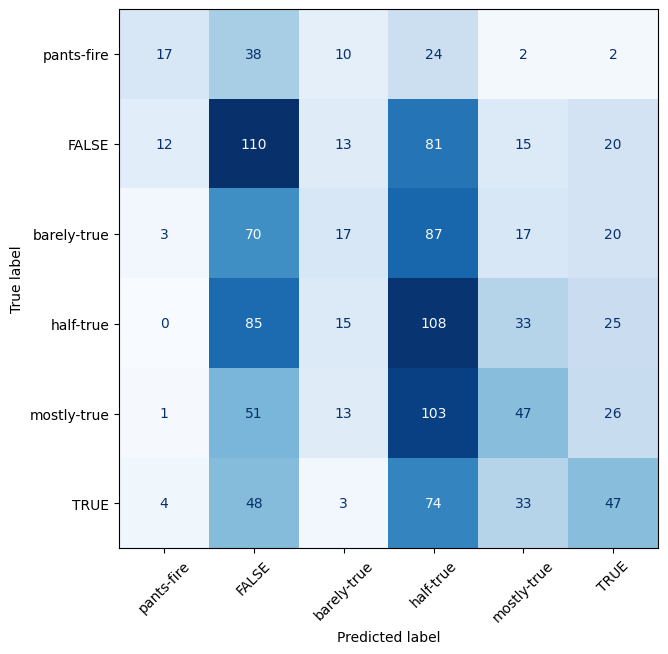

In [11]:
import json, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

LABELS = ["pants-fire","FALSE","barely-true","half-true","mostly-true","TRUE"]

with open("metrics/liar_softmax_metrics.json", "r", encoding="utf-8") as f:
    m = json.load(f)

cm = np.array(m["test"]["confusion_matrix"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.show()
